In [23]:
#This section of the code focuses on the modules import required to create the encoder-decoder seq2seq architecture.
import numpy as np
import itertools
import sys
import itertools
import numpy as np  # Matrix and vector computation package
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
import seaborn as sns  # Fancier plots
from sklearn.metrics import accuracy_score, classification_report
# Set seaborn plotting style
sns.set_style('darkgrid')
# Set the seed for reproducability
np.random.seed(seed=1)

In [24]:
#The section creates a tanh classifier for the tanh activation function using the OOP approach.
class TanH:
    """ Applies tanh activation function in the forward and backward propagation.
    """
    #The forward propagation
    def forward(self, x):
        return np.tanh(x)
    #The backward function to calculated the gradient.
    def backward(self, x, gradient):
        g_tanh = 1.0 - (x ** 2)
        return g_tanh * gradient


In [25]:
#The section creates a linear classifier for the linear activation function using the OOP approach.
class Linear:

    #The initialization
    def __init__(self, input_size: int, output_size: int, tensor_dim: int,
                    weights=None, bias=None):
        a = np.sqrt(6.0 / (input_size + output_size))
        self.W = (np.random.uniform(-a, a, (input_size, output_size))
                    if weights is None else weights)
        self.b = (np.zeros(output_size) if bias is None else bias)
        self.axes = tuple(range(tensor_dim - 1))

    #The forward propagation.
    def forward(self, x):
        """
        makes forward pass
        :param x: n-d tensor
        :return: linear transformation
        """
        return np.tensordot(x, self.W, axes=((-1), (0))) + self.b

    #This function calculates the gradient
    def backward(self, x, gradient):
        """
        :param x: n-d tensor
        :param gradient: gradient on previous step of backpropagation
        :return: gradient, g_w, g_b
        """
        # Same as: gW = np.einsum('ijk,ijl->kl', X, gY)
        # Same as: gW += np.dot(X[:,j,:].T, gY[:,j,:])
        #          (for i,j in X.shape[0:1])
        g_w = np.tensordot(x, gradient, axes=(self.axes, self.axes))
        g_b = np.sum(gradient, axis=self.axes)
        # Same as: gX = np.einsum('ijk,kl->ijl', gY, self.W.T)
        # Same as: gX[i,j,:] = np.dot(gY[i,j,:], self.W.T)
        #          (for i,j in gY.shape[0:1])
        gradient = np.tensordot(gradient, self.W.T, axes=((-1), (0)))
        return gradient, g_w, g_b





In [26]:
#The section creates a softmax classifier for the softmax activation function using the OOP approach.
class SoftmaxClassifier:
    # The forward propagation.
    def forward(self, x):
        """"param x: 3d tensor (batch_size, seq_length, input_size)
            return: softmax probabilities
        """
        x = x - np.expand_dims(np.max(x, axis=2), 2)
        exp = np.exp(x)
        exp_sum = exp.sum(-1)
        return exp / exp_sum[:,:,np.newaxis]
    
    #The loss function calculates the cross entropy loss which is the main method of performance evaluation for this model.
    def loss(self, y_pred, y_true):
        """
        Computes Cross entropy loss
        param y_pred: softmax activations (batch_size, seq_length, number_of_classes)
        param y_true: ground truth labels (batch_size, seq_length, 1)
        return: mean cross entropy loss over batch
        """

        seq_length = y_true.shape[1]

        losses = []
        for idx, p in enumerate(y_pred):
            # compute log likelihood
            log_likelihood = -np.log(p[range(seq_length), y_true[idx].flatten()])
            loss = np.sum(log_likelihood) / seq_length
            losses.append(loss)

        return np.mean(losses)

    #The backward function used to calculate the gradients of loss function.
    def backward(self, y_pred, y_true):
        """
        Computes gradients of loss function
        :param y_pred: softmax activations (batch_size, seq_length, number_of_classes)
        :param y_true: ground truth labels (batch_size, seq_length, 1)
        :return: gradient
        """

        delta = np.zeros(y_pred.shape)
        m = y_true.shape[1]

        for idx in range(len(delta)):
            grad = y_pred[idx]
            grad[range(m), y_true[idx].flatten()] -= 1
            # grad = grad / m
            delta[idx] = grad

        # return delta
        return delta / (y_pred.shape[0] * y_pred.shape[1])

In [27]:
#This is a single cell vanilla RNN class created with simply itertools and no automatic differentiation.

class RNNCell:
    #The RNN cell is initialized.
    def __init__(self, hidden_size, W, b):
        tensor_dim = 2
        self.linear = Linear(hidden_size, hidden_size, tensor_dim,
                                W, b)
        self.tanh = TanH()

    #The forward pass of the RNN cell.
    def forward(self, x, previous_state):
        """
        This function makes one forward pass
        :param x: 2d tensor (batch_size, hidden_size)
        :param previous_state: 2d tensor (batch_size x hidden_size) of rnn state on previous forward pass
        :return: rnn cell output
        """
        return self.tanh.forward(x + self.linear.forward(previous_state))

    #The backward propagation.
    def backward(self, previous_state, current_state, gradient_state):
        """
        :param previous_state: 2d tensor (batch_size x hidden_size) of rnn state
        :param current_state: 2d tensor (batch_size x hidden_size) of rnn state
        :param gradient_state: accumulated gradient during BPTT
        :return:gradient, gradient_state, g_w, g_b
        """

        gradient = self.tanh.backward(current_state, gradient_state)
        gradient_state, g_w, g_b = self.linear.backward(previous_state, gradient)
        return gradient, gradient_state, g_w, g_b

In [28]:
# Define layer that unfolds the states over time
class RNNLayer:
    """Unfold the recurrent states."""
    def __init__(self, hidden_size, sequence_length):
        a = np.sqrt(6. / (hidden_size * 2))
        self.W = np.random.uniform(-a, a, (hidden_size, hidden_size))
        self.b = np.zeros((self.W.shape[0]))
        self.rnn_cell = RNNCell(
            hidden_size, self.W, self.b)
        self.hidden_size = hidden_size
        self.sequence_length = sequence_length
        self.initial_state = np.zeros(hidden_size)

    def forward(self, x):
        """
        :param x: 3d tensor (batch_size, seq_length, input_length)
        :return: all hidden states
        """
        states = np.zeros((x.shape[0], x.shape[1] + 1, self.hidden_size))
        states[:, 0] = self.initial_state  # Set initial state

        for idx in range(self.sequence_length):
            # Update the states iteratively
            states[:, idx + 1] = self.rnn_cell.forward(x[:, idx], states[:, idx])
        return states

    def backward(self, x, states, input_gradient):
        """
        This method computes BPTT and returns all necessary gradients
        :param x: 3d tensor (batch_size, seq_length, input_length)
        :param states: 3d tensor of all rnn states (batch_size, seq_length, hidden_size)
        :param input_gradient: gradient value on previous layers
        :return: gradient, g_w_sum, g_b_sum, g_initial_state
        """

        # Initialise gradient of state outputs
        gradient_state = np.zeros_like(input_gradient[:, self.sequence_length - 1])

        # Initialse gradient tensor for state inputs
        gradient = np.zeros_like(x)
        g_w_sum = np.zeros_like(self.W)  # Initialise weight gradients
        g_b_sum = np.zeros_like(self.b)  # Initialise bias gradients

        # Propagate the gradients iteratively
        for k in range(self.sequence_length - 1, -1, -1):
            # Gradient at state output is gradient from previous state plus gradient from output
            gradient_state += input_gradient[:, k]

            # Propagate the gradient back through one state
            gradient[:, k], gradient_state, g_w, g_b = self.rnn_cell.backward(
                states[:, k], states[:, k + 1], gradient_state)

            g_w_sum += g_w  # Update total weight gradient
            g_b_sum += g_b  # Update total bias gradient

        # Get gradient of initial state over all samples
        g_initial_state = np.sum(gradient_state, axis=0)
        return gradient, g_w_sum, g_b_sum, g_initial_state


In [29]:
#This is the main seq2seq encoder-decoder architecture created by stacking RNN cells which is trained to sort numbers.
class ModelSort:
    #The initialisation
    def __init__(self, input_size: int, output_size: int, hidden_size: int,
                    sequence_len: int, tensor_dim: int = 3):
        tensor_dim = 3
        self.lr = 1e-3
        self.input_linear = Linear(input_size, hidden_size, tensor_dim)
        self.rnn = RNNLayer(hidden_size, sequence_len)
        self.output_linear = Linear(hidden_size, output_size, tensor_dim)
        self.classifier = SoftmaxClassifier()  # Classification output
        self.sequence_len = sequence_len

    #The forward propagation with updating the parameters.
    def train_on_batch(self, x_batch, y_batch):
        """
        This method makes forward run and update its parameters
        :param x_batch: 3d tensor (batch_size, seq_length, input_length)
        :param y_batch: 3d tensor (batch_size, seq_length, 1)
        :return:
        """
        linear_out, rnn_states, out, probabilities = self.forward(x_batch)
        gradients = self.backward(x_batch, probabilities, linear_out, rnn_states, y_batch)

    def forward(self, x_batch):
        """
        :param x_batch: 3d tensor (batch_size, seq_length, input_length)
        :return: linear_out, rnn_states, linear_out, probabilites
        """
        linear_out = self.input_linear.forward(x_batch)
        rnn_states = self.rnn.forward(linear_out)
        out = self.output_linear.forward(rnn_states[:, 1:self.sequence_len + 1, :])
        probabilities = self.classifier.forward(out)

        return linear_out, rnn_states, out, probabilities


    def backward(self, x_batch, y_pred, linear_out, rnn_states, y_batch):
        """
        Make computing of gradients and update parameters
        :param x_batch: 3d tensor (batch_size, seq_length, input_length)
        :param y_pred (batch_size, seq_length, number_of_classes)
        :param linear_out:
        :param rnn_states: 3d tensor of all rnn states (batch_size, seq_length, hidden_size)
        :param y_batch: 3d tensor (batch_size, seq_length, 1)
        :return:gradients
        """

        # get gradients for all layers
        gradient = self.classifier.backward(y_pred, y_batch)
        gradient, g_lout_w, g_lout_b = self.output_linear.backward(
            rnn_states[:, 1:self.sequence_len + 1, :], gradient)

        # Propagate gradient backwards through time
        gradient, g_rnn_w, g_rnn_b, g_init_state = self.rnn.backward(
            linear_out, rnn_states, gradient)

        g_x, g_lin_w, g_lin_b = self.input_linear.backward(x_batch, gradient)
        # Return the parameter gradients of: linear output weights,
        #  linear output bias, recursive weights, recursive bias, #
        #  linear input weights, linear input bias, initial state.

        gradients = [g for g in itertools.chain(
            np.nditer(g_init_state),
            np.nditer(g_lin_w),
            np.nditer(g_lin_b),
            np.nditer(g_rnn_w),
            np.nditer(g_rnn_b),
            np.nditer(g_lout_w),
            np.nditer(g_lout_b))]

        # update weights
        for idx, parameter in enumerate(self.get_params_iter()):
            parameter -= self.lr * gradients[idx]

        return gradients

    #These functions are used for the prediction section of the model to predict based on training.
    def predict_proba(self, x_batch):
        """
        :param x_batch: 3d tensor of (batch_size, seq_length, input_length)
        :return: y_proba (batch_size, seq_length, number_of_classes)
        """
        _, _, _, y_proba = self.forward(x_batch)
        return y_proba

    def predict(self, x_batch):
        """
        This method predicts class
        :param x_batch: 3d tensor of (batch_size, seq_length, input_length)
        :return: 2d tensor of predictions (batch_size, seq_length)
        """
        y_proba = self.predict_proba(x_batch)
        return np.argmax(y_proba, axis=2)

    def get_gradients(self, x_batch, y_batch):
        """Return the gradients with respect to input X and
        target T as a list. The list has the same order as the
        get_params_iter iterator."""
        linear_out, rnn_states, out, probabilities = self.forward(x_batch)
        return self.backward(x_batch, probabilities, linear_out, rnn_states, y_batch)

    #The cross entropy loss of the batch.
    def loss(self, y_pred, y_true):
        """
        :param y_pred: predicted probabilities (batch_size, seq_length, number_of_classes)
        :param y_true: true labels (batch_size, seq_length, 1)
        :return: Cross entropy loss over batch
        """
        return self.classifier.loss(y_pred, y_true)

    #The iterator function.
    def get_params_iter(self):
        """
        Returns iterator over all parameters in model;
        np.nditer is efficient iterator from numpy; parameters are iterable inplace
        """
        return itertools.chain(
            np.nditer(self.rnn.initial_state, op_flags=['readwrite']),
            np.nditer(self.input_linear.W, op_flags=['readwrite']),
            np.nditer(self.input_linear.b, op_flags=['readwrite']),
            np.nditer(self.rnn.W, op_flags=['readwrite']),
            np.nditer(self.rnn.b, op_flags=['readwrite']),
            np.nditer(self.output_linear.W, op_flags=['readwrite']),
            np.nditer(self.output_linear.b, op_flags=['readwrite']))

In [30]:
#This function creates a randomized data set for sorting.
def create_sort_dataset(dataset_length, seq_length, max_number=999, fraction=0.8):
    x_train = np.random.randint(low=0, high=max_number+1, size=(int(dataset_length*fraction),
                                                                seq_length,
                                                                1))
    y_train = np.sort(x_train, axis=1)
    
    x_test = np.random.randint(low=0, high=max_number+1, size=(int(dataset_length*(1-fraction)),
                                                                seq_length,
                                                                1))
    y_test = np.sort(x_test, axis=1)
    
    return x_train, y_train, x_test, y_test

#A dummy data set
def create_dummy_dataset(dataset_length, seq_length, max_number):
    lower_bound = -1 * max_number
    x_train = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_train = np.where(x_train.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    x_test = np.random.randint(low=lower_bound, high=max_number+1, size=(dataset_length, seq_length, 1))
    y_test = np.where(x_test.sum(axis=2) > 0, 1, 0).reshape(x_train.shape)
    
    return x_train, y_train, x_test, y_test
#The evaluation using cross entropy loss
def evaluate(y_test, x_test, model):
    y_pred = model.predict(x_test)
    loss = model.loss(model.predict_proba(x_test), y_test)
    
    print(f'Cross entropy loss {loss}')
    print('-'*100)
    print(classification_report(y_test.flatten(), y_pred.flatten()))

In [31]:
# Set hyper-parameters
batch_size = 20  # Size of the minibatches (number of samples)
max_num = 10 
seq_length = 5
hidden_size = 30 
dataset_size = 2000
epoch = 40

x_train, y_train, x_test, y_test = create_sort_dataset(dataset_size, seq_length, max_num)

input_size = 1
output_size = max_num+1

Epoch 1/40
TRAIN: Cross entropy loss:  2.734433111535017
VALIDATION: Cross entropy loss:  2.6867594294900736
Epoch 2/40
TRAIN: Cross entropy loss:  2.6315652899774715
VALIDATION: Cross entropy loss:  2.6069654633902304
Epoch 3/40
TRAIN: Cross entropy loss:  2.567190697873727
VALIDATION: Cross entropy loss:  2.55390525846204
Epoch 4/40
TRAIN: Cross entropy loss:  2.5223385977549437
VALIDATION: Cross entropy loss:  2.5155098077714872
Epoch 5/40
TRAIN: Cross entropy loss:  2.488935015541911
VALIDATION: Cross entropy loss:  2.4862935961779207
Epoch 6/40
TRAIN: Cross entropy loss:  2.4629719983660197
VALIDATION: Cross entropy loss:  2.4632593244100027
Epoch 7/40
TRAIN: Cross entropy loss:  2.4421202312947163
VALIDATION: Cross entropy loss:  2.4445757729903024
Epoch 8/40
TRAIN: Cross entropy loss:  2.4249099490949884
VALIDATION: Cross entropy loss:  2.4290541434820874
Epoch 9/40
TRAIN: Cross entropy loss:  2.4103721141299332
VALIDATION: Cross entropy loss:  2.4158913421148718
Epoch 10/40
TRA

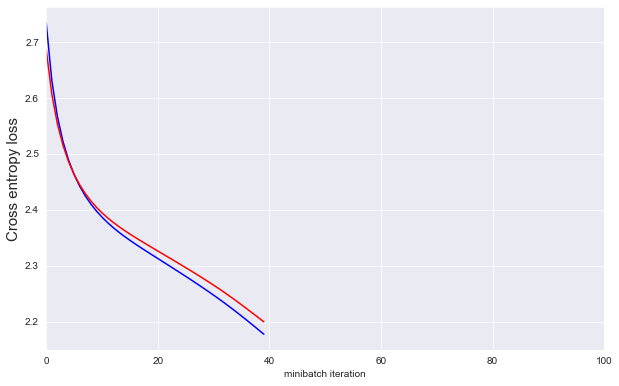

In [32]:
# Create the network
#The training of the encoder-decoder network
model = ModelSort(input_size, output_size, hidden_size, seq_length)
train_loss = []
validation_loss = []

for i in range(epoch):
    print(f'Epoch {i+1}/{epoch}')
    epoch_train_loss = []
    
    for mb in range(dataset_size // batch_size):
        x_batch = x_train[mb:mb + batch_size]  # Input minibatch
        y_batch = y_train[mb:mb + batch_size]  # Target minibatch
        model.train_on_batch(x_batch, y_batch)
        
        loss = model.loss(model.predict_proba(x_batch), y_batch)
        epoch_train_loss.append(loss)
    train_loss.append(np.mean(epoch_train_loss))
    validation_loss.append(model.loss(model.predict_proba(x_test), y_test))
    print("TRAIN: Cross entropy loss: ", train_loss[-1])
    print("VALIDATION: Cross entropy loss: ", validation_loss[-1])
# Plot the loss over the iterations
fig = plt.figure(figsize=(10, 7))
plt.plot(train_loss, 'b-')
plt.plot(validation_loss, 'r')
plt.xlabel('minibatch iteration')
plt.ylabel('Cross entropy loss', fontsize=15)
plt.xlim(0, 100)
fig.subplots_adjust(bottom=0.2)
plt.show()
#

In [33]:
#The evaluation report
evaluate(y_test, x_test, model)

Cross entropy loss 2.199794316489316
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.37      0.87      0.52       209
           1       0.55      0.07      0.13       152
           2       0.22      0.05      0.08       168
           3       0.23      0.31      0.26       176
           4       0.18      0.11      0.13       187
           5       0.07      0.01      0.01       180
           6       0.12      0.11      0.12       172
           7       0.16      0.50      0.25       209
           8       0.00      0.00      0.00       191
           9       0.13      0.11      0.12       159
          10       0.03      0.02      0.02       192

    accuracy                           0.21      1995
   macro avg       0.19      0.19      0.15      1995
weighted avg       0.18      0.21      0.16      1995



In [34]:
#The gradient checking of the model
model = ModelSort(input_size, output_size, hidden_size, seq_length)
# Get the gradients of the parameters from a subset of the data
backprop_grads = model.get_gradients(
    x_train[:100], y_train[:100])

eps = 1e-9  # Set the small change to compute the numerical gradient
# Compute the numerical gradients of the parameters in all layers.
for p_idx, param in enumerate(model.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    
    # + eps
    param += eps
    plus_loss = model.loss(
        model.predict_proba(x_train[0:100,:,:]), y_train[0:100,:,:])
    
    # - eps
    param -= 2 * eps
    min_loss = model.loss(
        model.predict_proba(x_train[0:100,:,:]), y_train[0:100,:,:])
    
    # reset param value
    param += eps
    
    # calculate numerical gradient
    grad_num = (plus_loss - min_loss) / (2*eps)
    numerator = np.linalg.norm(grad_backprop - grad_num)
    denominator = np.linalg.norm(grad_backprop) + np.linalg.norm(grad_num)
    difference = numerator / denominator
    
    if not np.isclose(grad_num, grad_backprop, ):
        print((
            f'Parameter id: {p_idx} '
            f'Numerical gradient of {grad_num} is not very close '
            f'to the backpropagation gradient of {grad_backprop}!'
        ))
        

Parameter id: 0 Numerical gradient of 0.007555289727179114 is not very close to the backpropagation gradient of 0.007568030528712834!
Parameter id: 1 Numerical gradient of -0.0052442494791193894 is not very close to the backpropagation gradient of -0.005277965431717676!
Parameter id: 2 Numerical gradient of 0.008135936369058072 is not very close to the backpropagation gradient of 0.008131413731813135!
Parameter id: 3 Numerical gradient of 0.002971622947711694 is not very close to the backpropagation gradient of 0.0029321404233255905!
Parameter id: 4 Numerical gradient of -0.015066392577978148 is not very close to the backpropagation gradient of -0.015009526948930593!
Parameter id: 6 Numerical gradient of 0.02219646688672583 is not very close to the backpropagation gradient of 0.022169127602243995!
Parameter id: 7 Numerical gradient of -0.007405853708064568 is not very close to the backpropagation gradient of -0.007390035541005654!
Parameter id: 8 Numerical gradient of 0.012651657499418